In [10]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
import torch
import torch.nn as nn
import dtnnlib as dtnn
# import resnet_cifar

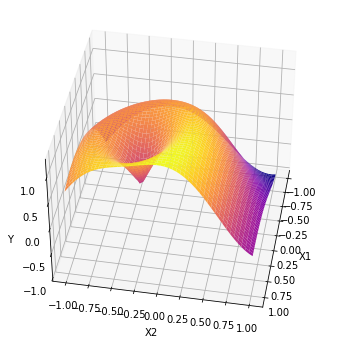

In [12]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1 + (X1+X2)/3

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
ax.view_init(elev=40., azim=10)

ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

# plt.savefig("./reg_toy_data.pdf", bbox_inches='tight')
plt.show()

In [13]:
device = torch.device("cuda:0")

## Define Model

In [14]:
def get_models(h = 5, device='cpu'):
    layer1 = {
        "l_0.5":dtnn.DistanceTransform(2, h, p=0.5),
        "l_1":dtnn.DistanceTransform(2, h, p=1),
        "l_2":dtnn.DistanceTransform(2, h),
        "l_inf":dtnn.DistanceTransform(2, h, p=20),
        "stereo":dtnn.StereographicTransform(2, h, bias=False),
        "linear":nn.Linear(2, h, bias=False)
    }
    net_dict = {}
    for key in layer1:
        net = nn.Sequential(
            layer1[key],
            nn.BatchNorm1d(h),
            nn.ELU(),
            nn.Linear(h, 1),
            )
        net_dict[key] = net.to(device)
    return net_dict

In [15]:
net_dict = get_models(10, device)

## Training step

In [16]:
criterion = nn.MSELoss()

In [17]:
xx, yy = xx.to(device), yy.to(device)

In [ ]:
mse_dict = {}
for key in net_dict:
    print("_________________________")
    print(f"Experimenting for {key}")
    net = net_dict[key]
    optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
    for epoch in range(20000):
        yout = net(xx)
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1)%100 == 0:
            print(f'Epoch: {epoch}, Loss:{float(loss)}')
            
            
        if (epoch+1)%1000 == 0:
            ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
            ax.scatter(X1, X2, Y, marker= '.')
            ax.scatter(X1, X2, yout.data.cpu().numpy().reshape(-1), color='r', marker='.')
            plt.show()
    mse_dict[key] = float(loss)
#     break

In [ ]:
mse_dict

In [ ]:
'''
## MSE dict for 5 neurons
{'l_0.5': 0.020136749371886253,
 'l_1': 0.016492752358317375,
 'l_2': 0.0055266194976866245,
 'l_inf': 0.006702724378556013,
 'stereo': 0.0016625970602035522,
 'linear': 0.017735350877046585}
 
## MSE dict for 10 neurons
{'l_0.5': 0.012882514856755733,
 'l_1': 0.0014265142381191254,
 'l_2': 0.00034334874362684786,
 'l_inf': 0.002438667695969343,
 'stereo': 0.0005292969872243702,
 'linear': 0.017327670007944107}
 
## MSE dict for 10 neurons (without layernorm)
{'l_0.5': 0.022727476432919502,
 'l_1': 0.0037993979640305042,
 'l_2': 0.00028794846730306745,
 'l_inf': 0.0027879432309418917,
 'stereo': 0.0003150099073536694,
 'linear': 0.0014082136331126094}
 
'''



## Any function as metric

In [18]:
class FunctionDT(nn.Module):
    
    def __init__(self, input_dim, num_centers, func, inv_temp=0.):
        '''
        func [input_dim -> 1]
        '''
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.func = func
        
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
    
    def forward(self, x):
        z = x.unsqueeze(1) - self.centers.unsqueeze(0)
        dists = self.func(z).squeeze(-1)
        dists = -dists*torch.exp(self.inv_temp)
        return dists

In [19]:
from classes import DistanceRegressor, ConvexNN
from nflib.flows import SequentialFlow, ActNorm
import nflib.res_flow as irf

In [20]:
# ## Convex
# func = ConvexNN([2, 10, 1])

In [21]:
# ## Invex
# actf = irf.LeakyReLU
# func = nn.Sequential(
#     irf.ResidualFlow(2, [10], activation=actf),
#     irf.ResidualFlow(2, [10], activation=actf),
#     DistanceRegressor(2),
#     )

In [22]:
## Ordinary
func = nn.Sequential(nn.Linear(2, 5), nn.ELU(), nn.Linear(5, 1))

In [23]:
func = func.to(device)
# func(xx).shape

In [24]:
# FunctionDT(2,2, func).to(device)(xx).shape

In [25]:
def get_models_func(h = 5, device='cpu'):
    layer1 = {
        "convex":ConvexNN([2, 20, 1]),
        "invex":nn.Sequential(
                    ActNorm(2)
                    irf.ResidualFlow(2, [20], activation=irf.LeakyReLU),
                    ActNorm(2)
#                     irf.ResidualFlow(2, [5], activation=irf.LeakyReLU),
                    DistanceRegressor(2),
                    ),
        "ordinary":nn.Sequential(nn.Linear(2, 20), nn.LeakyReLU(), nn.Linear(20, 1)),
    }
    net_dict = {}
    for key in layer1:
        net = nn.Sequential(
            FunctionDT(2, 5, layer1[key]),
            nn.BatchNorm1d(h),
            nn.ELU(),
            nn.Linear(h, 1),
            )
        net_dict[key] = net.to(device)
    return net_dict

SyntaxError: invalid syntax (192678252.py, line 6)

In [26]:
# net = nn.Sequential(
#         FunctionDT(2, 5, func),
#         nn.BatchNorm1d(5),
#         nn.ELU(),
#         nn.Linear(5, 1),
# )

In [ ]:
# net_dict = {"ord":net.to(device)}
net_dict = get_models_func(5, device)
net_dict

In [ ]:
mse_dict = {}
for key in net_dict:
    print("_________________________")
    print(f"Experimenting for {key}")
    net = net_dict[key]
    optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
    for epoch in range(20000):
        yout = net(xx)
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1)%100 == 0:
            print(f'Epoch: {epoch}, Loss:{float(loss)}')
            
            
        if (epoch+1)%1000 == 0:
            ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
            ax.scatter(X1, X2, Y, marker= '.')
            ax.scatter(X1, X2, yout.data.cpu().numpy().reshape(-1), color='r', marker='.')
            plt.show()
    mse_dict[key] = float(loss)
#     break

In [ ]:
a = 3
# fig = plt.figure(figsize=(8, 8))
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, key in enumerate(net_dict):
    ax[i].contourf(X1*a, X2*a, net_dict[key][0].func(xx*a).data.cpu().numpy().reshape(X1.shape), levels=20)
#     print(key)
plt.show()

In [ ]:
mse_dict

## Merge all models into single and benchmark

In [27]:
def get_models(h = 5, device='cpu'):
    layer1 = {
        "l_0.5":dtnn.DistanceTransform(2, h, p=0.5, bias=False),
        "l_1":dtnn.DistanceTransform(2, h, p=1, bias=False),
        "l_2":dtnn.DistanceTransform(2, h, bias=False),
        "l_inf":dtnn.DistanceTransform(2, h, p=20, bias=False),
        "stereo":dtnn.StereographicTransform(2, h, bias=False),
        "linear":nn.Linear(2, h, bias=False)
    }
    net_dict = {}
    for key in layer1:
        net = nn.Sequential(
            layer1[key],
            nn.BatchNorm1d(h),
            nn.ELU(),
            nn.Linear(h, 1),
            )
        net_dict[key] = net.to(device)
    return net_dict

In [29]:
def get_models_func(h = 5, func_h=20, device='cpu'):
    layer1 = {
        "convex":ConvexNN([2, func_h, 1]),
        "invex":nn.Sequential(
                    ActNorm(2),
                    irf.ResidualFlow(2, [func_h], activation=irf.LeakyReLU),
                    ActNorm(2),
                    DistanceRegressor(2),
                    ),
#         "ordinary":nn.Sequential(nn.Linear(2, func_h), nn.LeakyReLU(), nn.Linear(func_h, 1)),
        "ordinary":nn.Sequential(
                    ActNorm(2),
                    irf.ResidualFlow(2, [func_h], activation=irf.LeakyReLU),
                    ActNorm(2),
                    DistanceRegressor(2),
                    ),
    }
    irf.remove_spectral_norm_model(layer1["ordinary"])
    
    net_dict = {}
    for key in layer1:
        net = nn.Sequential(
            FunctionDT(2, h, layer1[key]),
            nn.BatchNorm1d(h),
            nn.ELU(),
            nn.Linear(h, 1),
            )
        net_dict[key] = net.to(device)
    return net_dict

In [ ]:
exp_mse_vals = {}
for h in [3, 5, 10]:
    net_dict = {**get_models(h, device=device), **get_models_func(h, device=device)}
    mse_dict = {}
    for key in net_dict:
        print("_________________________")
        print(f"Experimenting for {key}")
        net = net_dict[key]
        optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
        for epoch in range(20000):
            yout = net(xx)
            loss = criterion(yout, yy)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch+1)%100 == 0:
                print(f'Epoch: {epoch}, Loss:{float(loss)}')


            if (epoch+1)%1000 == 0:
                ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
                ax.scatter(X1, X2, Y, marker= '.')
                ax.scatter(X1, X2, yout.data.cpu().numpy().reshape(-1), color='r', marker='.')
                plt.show()
        mse_dict[key] = float(loss)
    exp_mse_vals[str(h)] = mse_dict

In [31]:
exp_mse_vals

{'3': {'l_0.5': 0.09315679967403412,
  'l_1': 0.03094426728785038,
  'l_2': 0.03708265349268913,
  'l_inf': 0.03419658541679382,
  'stereo': 0.006002770736813545,
  'linear': 0.1397106647491455,
  'convex': 0.018622344359755516,
  'invex': 0.0002579433494247496,
  'ordinary': 0.0001537915231892839},
 '5': {'l_0.5': 0.0569056011736393,
  'l_1': 0.015417991206049919,
  'l_2': 0.005586691666394472,
  'l_inf': 0.006714430637657642,
  'stereo': 0.002224668860435486,
  'linear': 0.013958037830889225,
  'convex': 0.002063347492367029,
  'invex': 0.00012867141049355268,
  'ordinary': 4.476966932998039e-05},
 '10': {'l_0.5': 0.012226426973938942,
  'l_1': 0.014927111566066742,
  'l_2': 0.0004994251648895442,
  'l_inf': 0.0016972831217572093,
  'stereo': 0.00032644838211126626,
  'linear': 0.005959363654255867,
  'convex': 0.0014069080352783203,
  'invex': 3.015560650965199e-05,
  'ordinary': 7.633106724824756e-05}}

In [1]:
a = 3
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, key in enumerate(["convex", "invex", "ordinary"]):
    ax[i].contourf(X1*a, X2*a, net_dict[key][0].func(xx*a).data.cpu().numpy().reshape(X1.shape), levels=20)
plt.show()

NameError: name 'plt' is not defined